In [13]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
from tableone import TableOne
wd = '/Users/timvigers/Dropbox/Work/Viral Shah/Day and Night CGM/'
sns.set_theme(style="whitegrid")
sns.set_palette("coolwarm")

In [14]:
# Import data
df = pd.read_csv(wd+'Data_Clean/analysis_data.csv',usecols=['ID','Age','HbA1c','14 Day TIR','14 Night TIR','14 Day Mean','14 Night Mean'])
df.columns = ['id','age','a1c','day_mbg','day_tir','night_mbg','night_tir']
# Get row with most sensor values for each person in JDRF data
jdrf = pd.read_csv(wd+'Data_Clean/analysis_data_jdrf.csv')
idx = jdrf.groupby('id',sort=False)['sensor_readings'].transform(max) == jdrf['sensor_readings']
jdrf = jdrf[idx]
idx = jdrf["sensor_readings"] >= 2822 # 70% cutoff for 2 weeks of data
jdrf = jdrf[idx]
# Combine
jdrf = jdrf[['id','age','a1c','day_mbg','day_tir','night_mbg','night_tir']]
df = pd.concat([df,jdrf])
df.reset_index(inplace=True,drop=True)

# Data Characteristics
- TIR was calculated using 2 weeks of CGM data prior to an office visit.
- For participants with multiple HbA1c measures, the CGM wear with the largest number of sensor readings was used. This was done to prevent auto-correlation between measures within a subject.
- CGM with < 70% wear were excluded.

In [15]:
# Split into HbA1c groups
df['a1c_group'] = pd.cut(df['a1c'],[0,7,8,9,10,float('inf')],right=False)
# Difference between day and night
df['tir_diff'] = df['day_tir'] - df['night_tir']
df['mbg_diff'] = df['day_mbg'] - df['night_mbg']

## Summary Table and Variable Distributions

In [16]:
columns = ['age','a1c','day_mbg','day_tir','night_mbg','night_tir','a1c_group','tir_diff','mbg_diff']
group = ['a1c_group']
TableOne(df, columns, groupby = group)

Grouped by a1c_group                                                                                    
                                   Missing       Overall    [0.0, 7.0)    [7.0, 8.0)    [8.0, 9.0)   [9.0, 10.0)   [10.0, inf)
n                                                    340           165           100            40            20            15
age, mean (SD)                           0   38.7 (14.5)   40.3 (13.1)   40.8 (14.8)   33.6 (15.6)   34.6 (16.4)   27.1 (12.5)
a1c, mean (SD)                           0     7.2 (1.4)     6.2 (0.5)     7.4 (0.2)     8.3 (0.3)     9.5 (0.3)    11.4 (1.0)
day_mbg, mean (SD)                       0  166.2 (35.7)  143.1 (23.6)  172.3 (16.4)  192.0 (16.8)  216.1 (29.5)  244.9 (42.0)
day_tir, mean (SD)                       0   60.5 (19.2)   73.3 (13.1)   56.3 (11.0)    45.9 (9.8)   33.4 (14.2)   22.1 (14.2)
night_mbg, mean (SD)                     0  169.1 (40.6)  143.9 (26.1)  178.1 (27.6)  197.3 (26.6)  219.3 (33.3)  244.1 (56.4)
night_tir, mean (SD)                     0   58.5 (22.0)   72.2 (15.7)   52.7 (17.7)   41.0 (15.1)   33.2 (15.9)   27.0 (19.2)
tir_diff, mean (SD)                      0    2.0 (13.6)    1.1 (12.3)    3.6 (14.7)    4.9 (14.0)    0.2 (15.6)   -4.9 (14.2)
mbg_diff, mean (SD)                      0   -2.9 (22.7)   -0.8 (18.9)   -5.8 (24.2)   -5.3 (24.5)   -3.2 (30.5)    0.9 (32.4)

## Mean Day and Night TIR

### By HbA1c Group

#### TIR

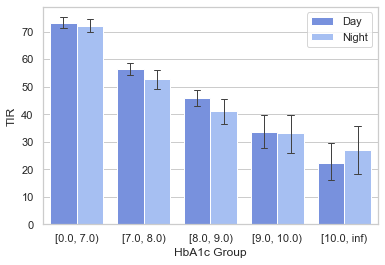

In [17]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_tir','night_tir'], value_name='TIR')
plot_df['variable'].replace({'day_tir':'Day','night_tir':'Night'},inplace=True)
# Plot
plot = sns.barplot(x='a1c_group',y='TIR',hue='variable',data=plot_df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group')
plot.legend(title='');

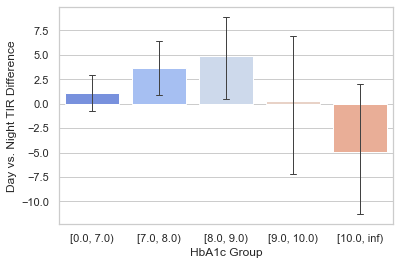

In [18]:
plot = sns.barplot(x='a1c_group',y='tir_diff',data=df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR Difference');

#### Mean Sensor Glucose

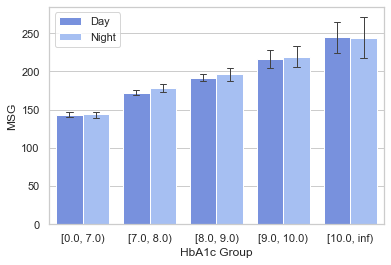

In [19]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_mbg','night_mbg'], value_name='MSG')
plot_df['variable'].replace({'day_mbg':'Day','night_mbg':'Night'},inplace=True)
# Plot
plot = sns.barplot(x='a1c_group',y='MSG',hue='variable',data=plot_df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group')
plot.legend(title='');

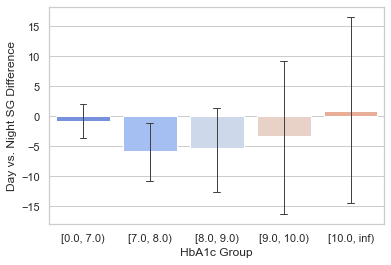

In [20]:
plot = sns.barplot(x='a1c_group',y='mbg_diff',data=df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night SG Difference');

Error bars indicate 95% confidence interval around the mean.

There were significant differences in day TIR, night TIR, day MSG, and night MSG by HbA1c group (p < 0.001 for all). However, the differences between day and night TIR and day and night MSG were not different between HbA1c groups (p = 0.08 and p = 0.42, respectively).

## Correlations Between All Variables

### Full Cohort

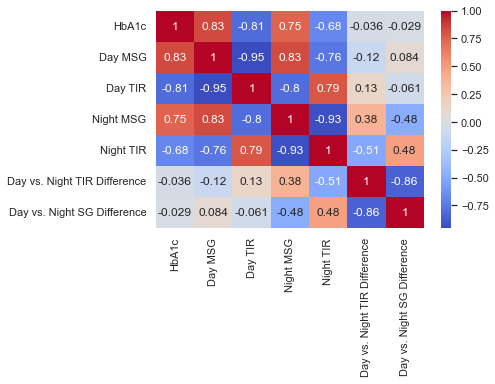

In [21]:
corr_mat = df[['a1c','day_mbg','day_tir','night_mbg','night_tir','a1c_group','tir_diff','mbg_diff']]
corr_mat.columns = ['HbA1c','Day MSG','Day TIR','Night MSG','Night TIR','HbA1c Group','Day vs. Night TIR Difference','Day vs. Night SG Difference']
c_full = corr_mat.corr()
sns.heatmap(c_full,annot=True,cmap="coolwarm");

In [22]:
corr_mat.corr()

,HbA1c,Day MSG,Day TIR,Night MSG,Night TIR,Day vs. Night TIR Difference,Day vs. Night SG Difference
HbA1c,1.000000,0.832328,-0.809077,0.746725,-0.681437,-0.035860,-0.028850
Day MSG,0.832328,1.000000,-0.952686,0.831087,-0.756464,-0.116529,0.083715
Day TIR,-0.809077,-0.952686,1.000000,-0.802401,0.790123,0.128643,-0.060697
Night MSG,0.746725,0.831087,-0.802401,1.000000,-0.930023,0.375721,-0.484616
Night TIR,-0.681437,-0.756464,0.790123,-0.930023,1.000000,-0.506212,0.476602
Day vs. Night TIR Difference,-0.035860,-0.116529,0.128643,0.375721,-0.506212,1.000000,-0.856495
Day vs. Night SG Difference,-0.028850,0.083715,-0.060697,-0.484616,0.476602,-0.856495,1.000000


### By HbA1c Group

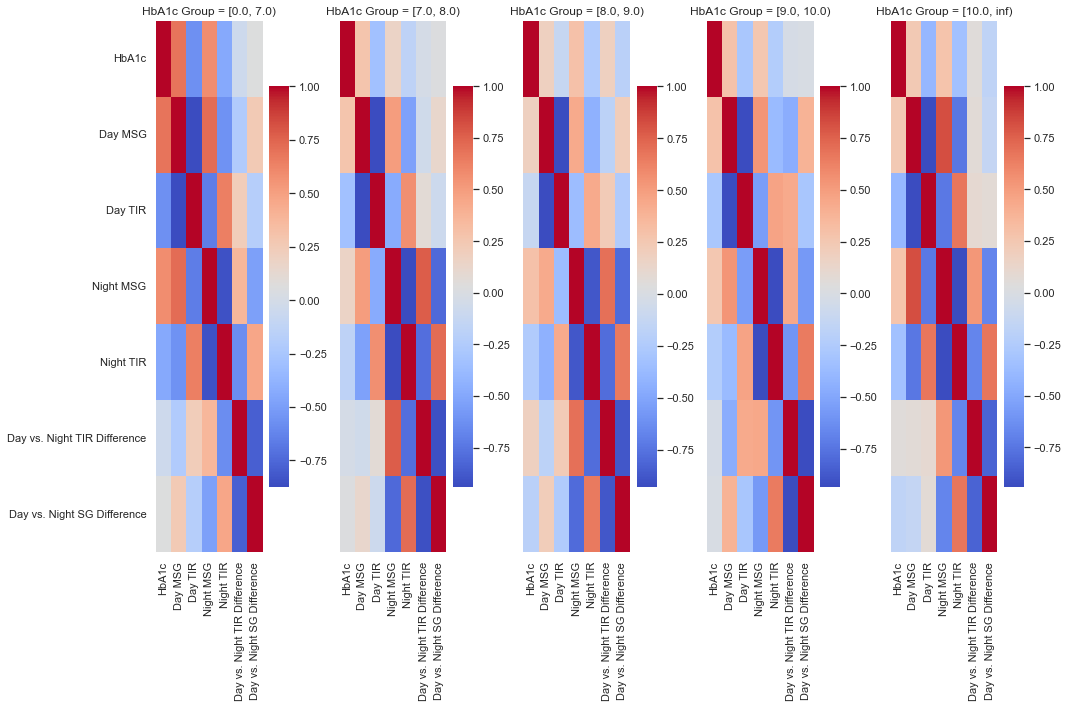

In [23]:
g = sns.FacetGrid(corr_mat, col='HbA1c Group')
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(),cmap="coolwarm"));

In [24]:
corr_mat.groupby('HbA1c Group').corr()

HbA1c   Day MSG   Day TIR  \
HbA1c Group                                                              
[0.0, 7.0)  HbA1c                         1.000000  0.692492 -0.568488   
            Day MSG                       0.692492  1.000000 -0.872078   
            Day TIR                      -0.568488 -0.872078  1.000000   
            Night MSG                     0.584410  0.715005 -0.655902   
            Night TIR                    -0.440592 -0.560810  0.648511   
            Day vs. Night TIR Difference -0.043362 -0.213357  0.237715   
            Day vs. Night SG Difference   0.057325  0.260799 -0.182749   
[7.0, 8.0)  HbA1c                         1.000000  0.266224 -0.334710   
            Day MSG                       0.266224  1.000000 -0.935374   
            Day TIR                      -0.334710 -0.935374  1.000000   
            Night MSG                     0.144091  0.492880 -0.481863   
            Night TIR                    -0.180637 -0.531237  0.562761   
            Day vs. Night TIR Difference -0.033283 -0.061116  0.071589   
            Day vs. Night SG Difference   0.016273  0.116330 -0.085028   
[8.0, 9.0)  HbA1c                         1.000000  0.183548 -0.121098   
            Day MSG                       0.183548  1.000000 -0.928027   
            Day TIR                      -0.121098 -0.928027  1.000000   
            Night MSG                     0.294848  0.434123 -0.360679   
            Night TIR                    -0.248049 -0.431919  0.432887   
            Day vs. Night TIR Difference  0.183408 -0.180505  0.229625   
            Day vs. Night SG Difference  -0.193889  0.214614 -0.244919   
[9.0, 10.0) HbA1c                         1.000000  0.285583 -0.290018   
            Day MSG                       0.285583  1.000000 -0.929814   
            Day TIR                      -0.290018 -0.929814  1.000000   
            Night MSG                     0.257758  0.533436 -0.551043   
            Night TIR                    -0.233825 -0.375013  0.465501   
            Day vs. Night TIR Difference -0.024520 -0.460418  0.431803   
            Day vs. Night SG Difference  -0.005254  0.384469 -0.297406   
[10.0, inf) HbA1c                         1.000000  0.237723 -0.409022   
            Day MSG                       0.237723  1.000000 -0.938646   
            Day TIR                      -0.409022 -0.938646  1.000000   
            Night MSG                     0.274933  0.822702 -0.738838   
            Night TIR                    -0.339091 -0.744061  0.672382   
            Day vs. Night TIR Difference  0.048826  0.066168  0.091369   
            Day vs. Night SG Difference  -0.170908 -0.137264  0.070665   

                                          Night MSG  Night TIR  \
HbA1c Group                                                      
[0.0, 7.0)  HbA1c                          0.584410  -0.440592   
            Day MSG                        0.715005  -0.560810   
            Day TIR                       -0.655902   0.648511   
            Night MSG                      1.000000  -0.845408   
            Night TIR                     -0.845408   1.000000   
            Day vs. Night TIR Difference   0.380085  -0.585224   
            Day vs. Night SG Difference   -0.488452   0.467436   
[7.0, 8.0)  HbA1c                          0.144091  -0.180637   
            Day MSG                        0.492880  -0.531237   
            Day TIR                       -0.481863   0.562761   
            Night MSG                      1.000000  -0.939176   
            Night TIR                     -0.939176   1.000000   
            Day vs. Night TIR Difference   0.771544  -0.784211   
            Day vs. Night SG Difference   -0.806853   0.711381   
[8.0, 9.0)  HbA1c                          0.294848  -0.248049   
            Day MSG                        0.434123  -0.431919   
            Day TIR                       -0.360679   0.432887   
            Night MSG                      1.000000 